# SENTIMENT ANALYSIS MODEL FOR DEPLOYMENT IN KENYA'S CONSTRUCTION SECTOR FOR SERVICE CLASSIFICATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets evaluate torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# For data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For handling model training
import torch
from sklearn.model_selection import train_test_split
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## Importing the datasets

In [ ]:
english_data = pd.read_csv('/content/drive/MyDrive/datasets/csv/data_english.csv', encoding='latin1')
swahili_data = pd.read_csv('/content/drive/MyDrive/datasets/csv/data_swahili.csv', encoding='latin1')

In [ ]:
english_data.head()

,Text,Ratings
0,"Worst company ever, highly unprofessional tech...",1
1,Feeling LOOTED!!!!!....For Chimney Cleaning .....,1
2,"Wastage of money and time, there professionals...",1
3,I recently booked a full-body massage from Urb...,1
4,Urban company showcases that its organised. F...,1


In [ ]:
english_data.shape

(501, 2)

In [ ]:
swahili_data.head()

,Text,Sentiment
0,yeye ni mrembo sana,positive
1,Tunaipenda hii ngoma sana,positive
2,yani nahisi mapenzi hadi kwa miguu?? naipenda ...,positive
3,Waah hii ngoma ilikua imeshika nikiwa darasa l...,positive
4,Safi mgenge????2018 na hii ngoma bado ni moto,positive


In [ ]:
swahili_data.shape

(687, 2)

### Manipulating the english dataset

The structure needed before training the model should be: Text, Sentiment - similar to the swahili dataset. We shall use the rating to get this structure.

In [ ]:
# Check different data and confirm data types
print(english_data.head())
print(english_data.dtypes)

                                                Text Ratings
0  Worst company ever, highly unprofessional tech...       1
1  Feeling LOOTED!!!!!....For Chimney Cleaning .....       1
2  Wastage of money and time, there professionals...       1
3  I recently booked a full-body massage from Urb...       1
4  Urban company showcases that its organised. F...       1
Text       object
Ratings    object
dtype: object


In [ ]:
# Print unique data in Ratings column
print(english_data['Ratings'].unique())

['1' '2' '5' '3' '4' 'Ratings']


In [ ]:
english_data['Ratings'] = pd.to_numeric(english_data['Ratings'], errors='coerce')

In [ ]:
english_data = english_data.dropna(subset=['Ratings'])

In [ ]:
# Change Ratings values from strings to integers
english_data['Ratings'] = english_data['Ratings'].astype(int)

<ipython-input-14-33d9a9e74320>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_data['Ratings'] = english_data['Ratings'].astype(int)


In [ ]:
# Assign positive and negative classes to text data based on ratings - ratings of 1 or 2 are classified as regative
english_data['Sentiment'] = english_data['Ratings'].apply(lambda x: 'negative' if x <= 2 else 'positive')

<ipython-input-15-04f94fb7d431>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_data['Sentiment'] = english_data['Ratings'].apply(lambda x: 'negative' if x <= 2 else 'positive')


In [ ]:
english_data.head()

,Text,Ratings,Sentiment
0,"Worst company ever, highly unprofessional tech...",1,negative
1,Feeling LOOTED!!!!!....For Chimney Cleaning .....,1,negative
2,"Wastage of money and time, there professionals...",1,negative
3,I recently booked a full-body massage from Urb...,1,negative
4,Urban company showcases that its organised. F...,1,negative


In [ ]:
# Drop "Ratings" column
english_data = english_data.drop(columns=['Ratings'])

### Verifying structure of both datasets

In [ ]:
english_data.head()

,Text,Sentiment
0,"Worst company ever, highly unprofessional tech...",negative
1,Feeling LOOTED!!!!!....For Chimney Cleaning .....,negative
2,"Wastage of money and time, there professionals...",negative
3,I recently booked a full-body massage from Urb...,negative
4,Urban company showcases that its organised. F...,negative


In [ ]:
swahili_data.head()

,Text,Sentiment
0,yeye ni mrembo sana,positive
1,Tunaipenda hii ngoma sana,positive
2,yani nahisi mapenzi hadi kwa miguu?? naipenda ...,positive
3,Waah hii ngoma ilikua imeshika nikiwa darasa l...,positive
4,Safi mgenge????2018 na hii ngoma bado ni moto,positive


### Merging the two datasets

In [ ]:
# Merge english_data and swahili_data into a new dataframe text_data
text_data = pd.concat([english_data, swahili_data], ignore_index=True)

In [ ]:
text_data.shape

(1187, 2)

In [ ]:
text_data.head()

,Text,Sentiment
0,"Worst company ever, highly unprofessional tech...",negative
1,Feeling LOOTED!!!!!....For Chimney Cleaning .....,negative
2,"Wastage of money and time, there professionals...",negative
3,I recently booked a full-body massage from Urb...,negative
4,Urban company showcases that its organised. F...,negative


In [ ]:
text_data.tail()

,Text,Sentiment
1182,Ni mbaya sana kwamba kila mtu mwingine aliyehu...,negative
1183,ni dharau kwa akili ya mtu na upotezaji mkubwa...,negative
1184,Ila mbaya!,negative
1185,"Kwa neno moja, ni aibu",negative
1186,"Kwa bahati mbaya, fadhila yoyote katika kazi y...",negative


Now we randomise the order of the records to allow our model to encounter random text of either english or swahili as it is training

In [ ]:
# Randomize the order of records in the text_data dataframe
text_data = text_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
text_data.head()

,Text,Sentiment
0,"The handyman did a good job, and Im happy wit...",positive
1,Mtu anayeongoza hana dhamana.,negative
2,"Kwa kumalizia, sitajisumbua na sinema hii kwa ...",negative
3,I booked a plumber to check for smell from a s...,negative
4,Lakini wakati mtu anajitahidi kwa ukuu na usha...,negative


In [ ]:
# Checking for null values in the merged data frame
text_data.isnull().sum()

,0
Text,0
Sentiment,0


## Data visualisation

<ipython-input-27-cbbbfd2dabc6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=text_data, x='Sentiment', palette='Set2')


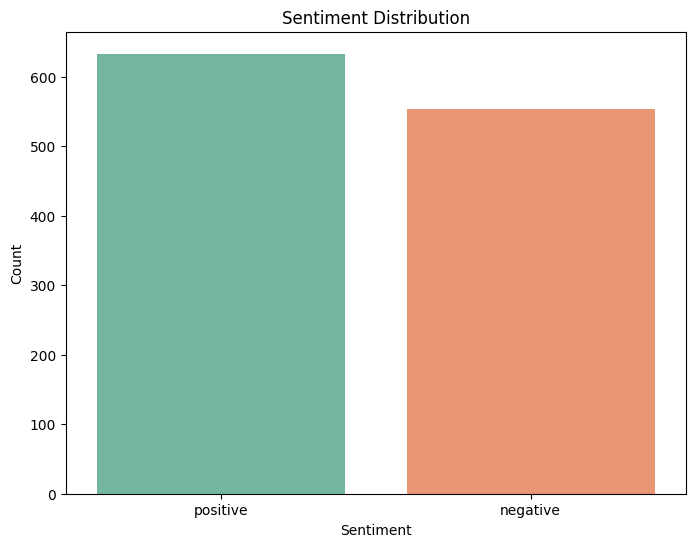

In [ ]:
# Plotting the distribution of sentiments
plt.figure(figsize=(8, 6))
sns.countplot(data=text_data, x='Sentiment', palette='Set2')
plt.title('Sentiment Distribution')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()


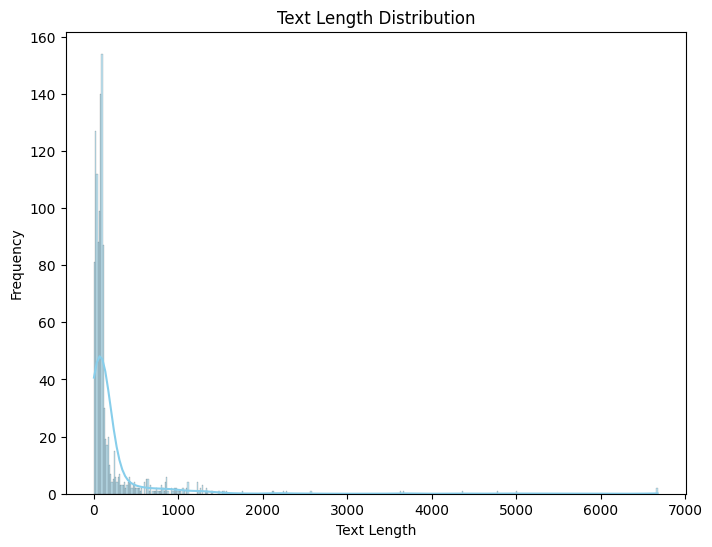

In [ ]:
# Calculate the length of each text entry
text_data['Text_Length'] = text_data['Text'].apply(len)

# Plotting the text length distribution
plt.figure(figsize=(8, 6))
sns.histplot(text_data['Text_Length'], kde=True, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud

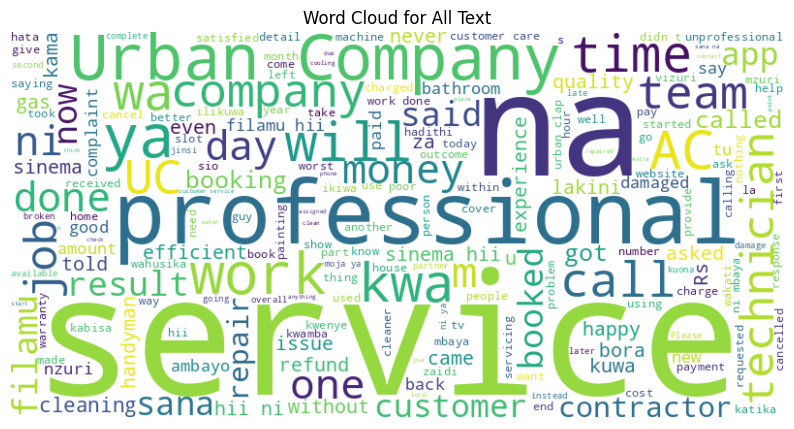

In [ ]:
# Word cloud for all text data
all_text = ' '.join(text_data['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Text')
plt.show()

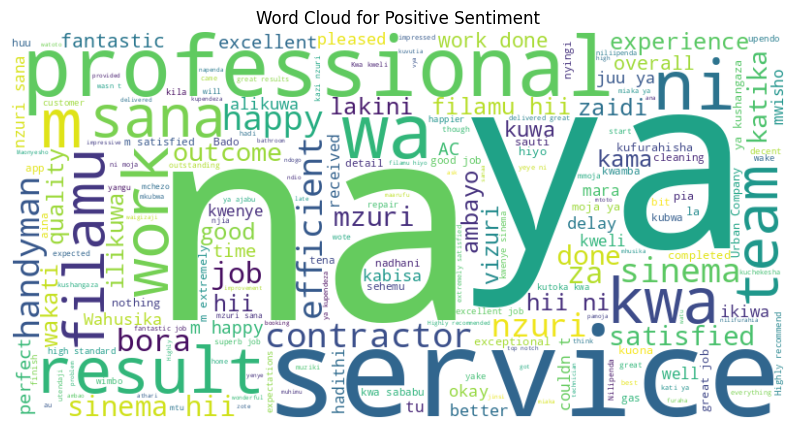

In [ ]:
# Word cloud for positive sentiment
positive_text = ' '.join(text_data[text_data['Sentiment'] == 'positive']['Text'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 8))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

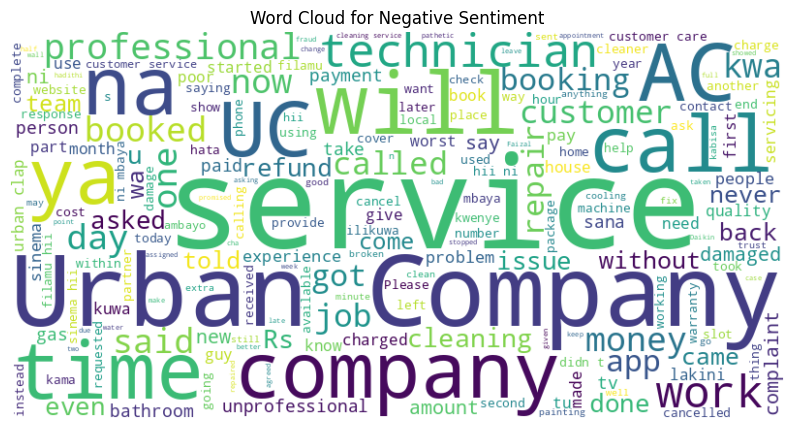

In [ ]:
# Word cloud for negative sentiment
negative_text = ' '.join(text_data[text_data['Sentiment'] == 'negative']['Text'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 8))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

## Model training

In [ ]:
# Rename columns for clarity
text_data.rename(columns={'Text': 'text', 'Sentiment': 'label'}, inplace=True)

In [ ]:
text_data.head()

,text,label,Text_Length
0,"The handyman did a good job, and Im happy wit...",positive,100
1,Mtu anayeongoza hana dhamana.,negative,29
2,"Kwa kumalizia, sitajisumbua na sinema hii kwa ...",negative,111
3,I booked a plumber to check for smell from a s...,negative,570
4,Lakini wakati mtu anajitahidi kwa ukuu na usha...,negative,278


### Data encoding and splitting

In [ ]:
# Encode labels (positive -> 1, negative -> 0)
text_data['label'] = text_data['label'].apply(lambda x: 1 if x == 'positive' else 0)

# Train-test split (80-20)
train_df, test_df = train_test_split(text_data, test_size=0.2, random_state=42)

### Convert Data to Hugging Face Dataset Format

In [ ]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Load XLM-R tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove unused columns and set format for PyTorch
train_dataset = train_dataset.remove_columns(['text', '__index_level_0__'])
test_dataset = test_dataset.remove_columns(['text', '__index_level_0__'])
train_dataset.set_format(type='torch')
test_dataset.set_format(type='torch')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Map:   0%|          | 0/949 [00:00<?, ? examples/s]

Map:   0%|          | 0/238 [00:00<?, ? examples/s]

### Load the Pre-trained XLM-RoBERTa Model

In [ ]:
# Load the pre-trained XLM-R model for sequence classification
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define Evaluation Metrics

In [ ]:
# Define evaluation metric
f1_metric = evaluate.load("f1")

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(predictions=predictions, references=labels)

### Set Training Arguments

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    lr_scheduler_type='cosine',
    warmup_steps=500,
    gradient_accumulation_steps=2,
    fp16=True,
    gradient_checkpointing=True  # Save GPU memory
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Initialize the Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

<ipython-input-42-751e60decfb7>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,F1
0,0.721900,0.698027,0.345238
2,0.651400,0.528187,0.731915
4,0.498600,0.386577,0.850909
6,0.344600,0.486526,0.867314
8,0.303800,0.555071,0.864662
10,0.232300,0.652996,0.876325
12,0.158800,0.717933,0.891228
14,0.139700,0.764725,0.892086
16,0.142700,0.663225,0.902527
18,0.083800,0.769275,0.903226


TrainOutput(global_step=1487, training_loss=0.2502692921216166, metrics={'train_runtime': 1609.5394, 'train_samples_per_second': 58.961, 'train_steps_per_second': 3.666, 'total_flos': 1560577447104000.0, 'train_loss': 0.2502692921216166, 'epoch': 24.991596638655462})

In [ ]:
# Evaluate on test set
results = trainer.evaluate()
print(f"F1 Score: {results['eval_f1']:.4f}")

F1 Score: 0.9046


### Confusion matrix for performance visualization


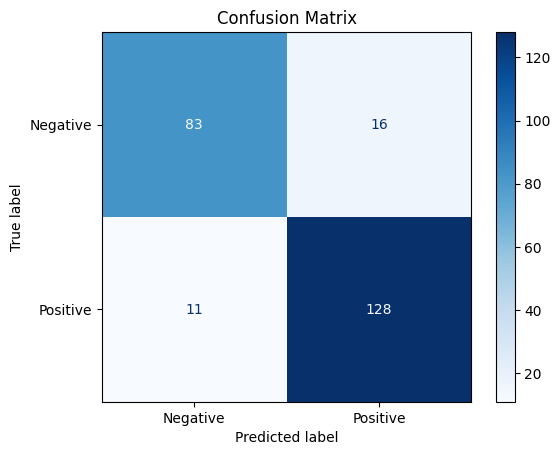

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test dataset
test_predictions = trainer.predict(test_dataset)
predicted_labels = test_predictions.predictions.argmax(axis=1)
true_labels = test_predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


## Evaluating the model with text examples

In [ ]:
from transformers import pipeline

In [ ]:
# Load the sentiment analysis pipeline with the fine-tuned model
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Create a mapping from label index to sentiment class
label_map = {0: 'negative', 1: 'positive'}

# Function to test sentiment of a given text
def predict_sentiment(text):
    result = nlp(text)
    sentiment_label = result[0]['label']

    # Convert the label (LABEL_0, LABEL_1) to numeric value and map it to sentiment class
    numeric_label = int(sentiment_label.split('_')[1])  # Extract 0 or 1 from 'LABEL_0', 'LABEL_1'
    sentiment = label_map[numeric_label]
    return sentiment

In [ ]:
# Test reviews (Positive and Negative) in both English and Swahili
reviews = {
    "english_positive": "The construction team has been very efficient. The project is ahead of schedule, and the quality of work is exceptional. I am very pleased with the progress.",
    "english_negative": "The construction work has been delayed multiple times, and the quality of materials used is subpar. The team has been unresponsive to our concerns, and I'm frustrated with the progress.",
    "swahili_positive": "Timu ya ujenzi imekuwa na ufanisi mkubwa. Mradi uko mbele ya ratiba, na ubora wa kazi ni wa kipekee. Nina furaha kubwa na maendeleo ya mradi.",
    "swahili_negative": "Kazi ya ujenzi imeshindwa mara kadhaa na ubora wa vifaa vilivyotumika ni hafifu. Timu haijajibu maswali yetu, na nina machungu na maendeleo ya mradi."
}

# Classify each review
for review_type, review_text in reviews.items():
    sentiment = predict_sentiment(review_text)
    print(f"{review_type}: {sentiment}")


english_positive: positive
english_negative: negative
swahili_positive: positive
swahili_negative: negative


In [ ]:
# Test reviews (Negative first, Positive second) in both English and Swahili
reviews = {
    "english_negative": "Communication with the team has been poor, and I am dissatisfied with the progress. The construction project has faced several delays, and the quality of work is not up to the mark.",
    "english_positive": "I highly recommend their services. The construction crew did a fantastic job. They completed the project ahead of time, and the quality of the materials used was top-notch.",
    "swahili_negative": "Mawasiliano na timu ni duni, na sina furaha na maendeleo. Mradi wa ujenzi umekumbwa na ucheleweshaji mwingi, na ubora wa kazi sio wa kuridhisha.",
    "swahili_positive": "Napendekeza huduma zao bila shaka. Timu ya ujenzi imefanya kazi nzuri sana. Mradi umekamilika mapema na ubora wa vifaa ulitumika ni bora sana."
}

# Classify each review
for review_type, review_text in reviews.items():
    sentiment = predict_sentiment(review_text)
    print(f"{review_type}: {sentiment}")


english_negative: negative
english_positive: positive
swahili_negative: positive
swahili_positive: positive


In [ ]:
# Test reviews (Positive first, Negative second) in both English and Swahili
reviews = {
    "english_positive": "The project was completed with exceptional quality and on time. The team was very professional, and the communication throughout was great. I am extremely satisfied with the final result.",
    "english_negative": "The construction delays were frustrating, and the quality of the work was poor. I had difficulty getting in touch with the team, and the overall experience was disappointing.",
    "swahili_positive": "Timu ya ujenzi imefanya kazi nzuri na mradi umehitimishwa kwa ubora wa kipekee. Mawasiliano yalikuwa bora na nimefurahi sana na matokeo ya mwisho.",
    "swahili_negative": "Ucheleweshaji wa ujenzi ulikuwa wa kutia hasira na ubora wa kazi haukuwa mzuri. Nilikuwa na shida ya kuwasiliana na timu, na uzoefu mzima ulikuwa wa kukatisha tamaa."
}

# Classify each review
for review_type, review_text in reviews.items():
    sentiment = predict_sentiment(review_text)
    print(f"{review_type}: {sentiment}")


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


english_positive: positive
english_negative: negative
swahili_positive: positive
swahili_negative: negative


## Saving the trained model

In [ ]:
model.save_pretrained('/content/drive/MyDrive/sentiment_model')

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/sentiment_model')

('/content/drive/MyDrive/sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/sentiment_model/sentencepiece.bpe.model',
 '/content/drive/MyDrive/sentiment_model/added_tokens.json')